In [ ]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.3'
spark_version = 'spark-3.5.5'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,955 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,000 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/mu

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
import time
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
from pyspark.sql.types import DoubleType
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
import xgboost as xgb
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from pyspark.ml.feature import VectorAssembler

In [ ]:
# Create a Spark session
spark = SparkSession.builder.appName("CSV to Spark").getOrCreate()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving winemag-data-clean.csv to winemag-data-clean.csv


In [ ]:
# Replace 'your_file.csv' with the uploaded CSV filename
wine_df = spark.read.csv("winemag-data-clean.csv", header=True, inferSchema=True)

# Show the first few rows of the DataFrame
wine_df.show()

+---------+------+-----+-----------------+-------------------+------------------+--------------------+------------------+-------------------+------------+-------+---------------+
|  country|points|price|         province|           region_1|       taster_name|               title|           variety|             winery|vintage_year|  style|rating_category|
+---------+------+-----+-----------------+-------------------+------------------+--------------------+------------------+-------------------+------------+-------+---------------+
| Portugal|    87| 15.0|            Douro|              Douro|        Roger Voss|Quinta dos Avidag...|    Portuguese Red|Quinta dos Avidagos|        2011|    red|           good|
|       US|    87| 14.0|           Oregon|  Willamette Valley|      Paul Gregutt|Rainstorm 2013 Pi...|        Pinot Gris|          Rainstorm|        2013|unknown|           good|
|       US|    87| 13.0|         Michigan|Lake Michigan Shore|Alexander Peartree|St. Julian 2013 R...|   

In [ ]:
# Check for missing values in each column
wine_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in wine_df.columns]).show()

+-------+------+-----+--------+--------+-----------+-----+-------+------+------------+-----+---------------+
|country|points|price|province|region_1|taster_name|title|variety|winery|vintage_year|style|rating_category|
+-------+------+-----+--------+--------+-----------+-----+-------+------+------------+-----+---------------+
|      0|     0|    0|       0|       0|          0|    1|      2|     2|           2|    2|              2|
+-------+------+-----+--------+--------+-----------+-----+-------+------+------------+-----+---------------+



In [ ]:
# Summary statistics for numerical columns
wine_df.describe().show()

+-------+---------+--------------------+------------------+--------+--------+------------------+--------------------+--------+--------+------------------+------+---------------+
|summary|  country|              points|             price|province|region_1|       taster_name|               title| variety|  winery|      vintage_year| style|rating_category|
+-------+---------+--------------------+------------------+--------+--------+------------------+--------------------+--------+--------+------------------+------+---------------+
|  count|   116766|              116766|            116766|  116766|  116766|            116766|              116765|  116764|  116764|            116764|116764|         116764|
|   mean|     NULL|   88.45757718494411|35.502316618849825|  2009.0|    NULL|              NULL|                NULL|    NULL|Infinity|2010.7266965845638|  NULL|           NULL|
| stddev|     NULL|  3.0454983210493283| 41.21818848393427|    NULL|    NULL|              NULL|              

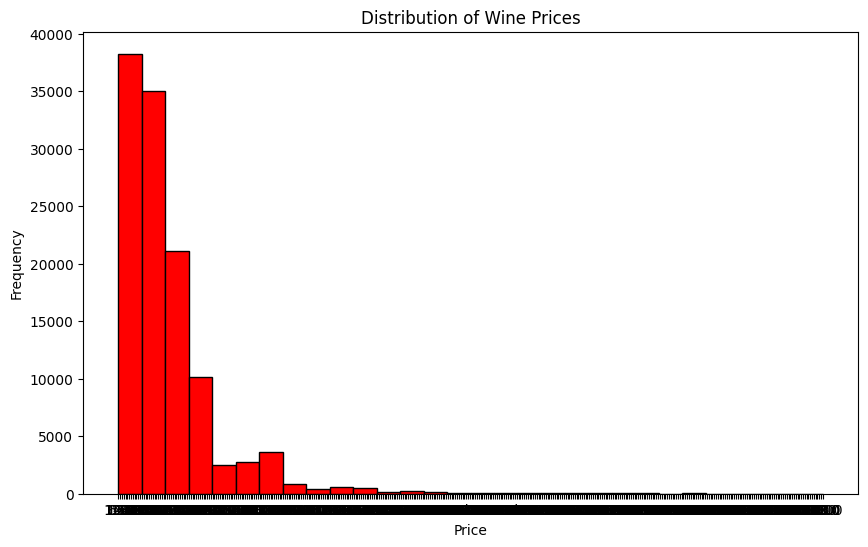

In [ ]:
# Collect price data and convert to Pandas for plotting
price_data = wine_df.select('price').toPandas()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(price_data['price'], bins=30, color='red', edgecolor='black')
plt.title("Distribution of Wine Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

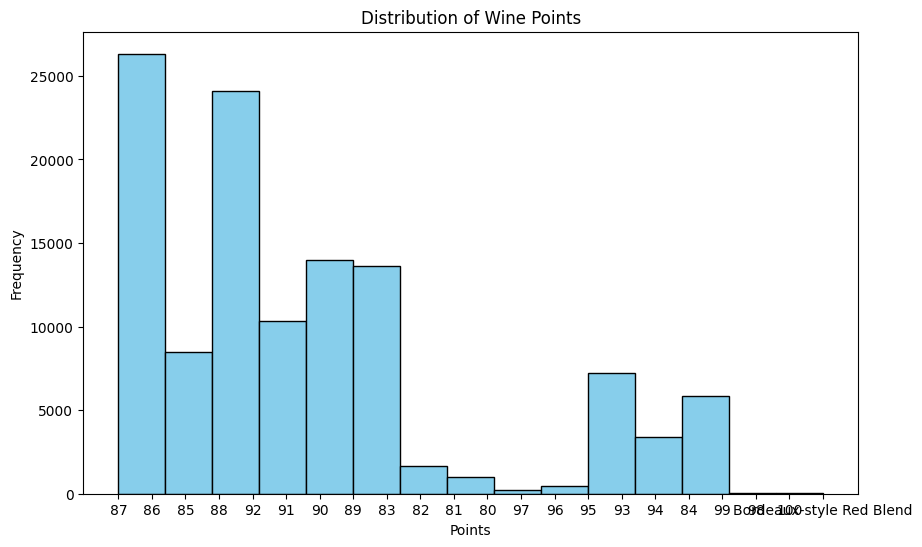

In [ ]:
# Collect points data and convert to Pandas for plotting
points_data = wine_df.select('points').toPandas()

# Plot the histogram for points
plt.figure(figsize=(10, 6))
plt.hist(points_data['points'], bins=15, color='skyblue', edgecolor='black')
plt.title("Distribution of Wine Points")
plt.xlabel("Points")
plt.ylabel("Frequency")
plt.show()

In [ ]:
wine_df.printSchema()

root
 |-- country: string (nullable = true)
 |-- points: string (nullable = true)
 |-- price: string (nullable = true)
 |-- province: string (nullable = true)
 |-- region_1: string (nullable = true)
 |-- taster_name: string (nullable = true)
 |-- title: string (nullable = true)
 |-- variety: string (nullable = true)
 |-- winery: string (nullable = true)
 |-- vintage_year: integer (nullable = true)
 |-- style: string (nullable = true)
 |-- rating_category: string (nullable = true)



In [ ]:
# Convert 'price' column to DoubleType
wine_df = wine_df.withColumn("points", wine_df["points"].cast("double"))
wine_df = wine_df.withColumn("price", wine_df["price"].cast("double"))
wine_df = wine_df.withColumn("vintage_year", wine_df["vintage_year"].cast("integer"))

In [ ]:
# Correlation matrix for numerical columns
correlation_points_price = wine_df.stat.corr('points', 'price')
correlation_points_vintage = wine_df.stat.corr('points', 'vintage_year')

print(f"Correlation between points and price: {correlation_points_price}")
print(f"Correlation between points and vintage year: {correlation_points_vintage}")

Correlation between points and price: 0.41367276157378663
Correlation between points and vintage year: 0.07933058499432911


<ipython-input-13-10ce9a58aca2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='country', y='count', data=country_data, palette='Set2')


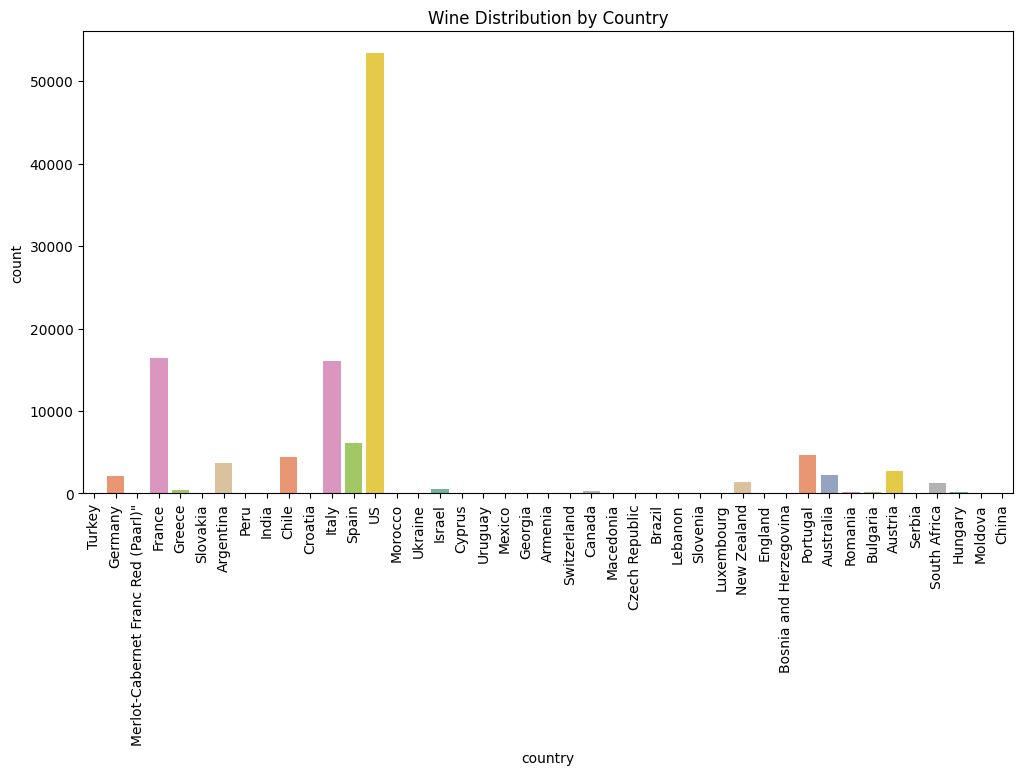

In [ ]:
# Collect wine country data and convert to Pandas
country_data = wine_df.groupBy('country').count().toPandas()

# Plot the count distribution for country
# Plot the count distribution for country
plt.figure(figsize=(12, 6))
sns.barplot(x='country', y='count', data=country_data, palette='Set2')
plt.title("Wine Distribution by Country")
plt.xticks(rotation=90)
plt.show()

In [ ]:
wine_df.groupBy('rating_category').agg(F.avg('points').alias('avg_points')).show()

df= wine_df.toPandas()
df.describe()

+---------------+-----------------+
|rating_category|       avg_points|
+---------------+-----------------+
|      very good|91.39396308669178|
|           NULL|             90.0|
|        average| 83.1601569466738|
|      excellent|95.58565555047967|
|           good|87.14718579324328|
+---------------+-----------------+



,points,price,vintage_year
count,116765.000000,116765.000000,116764.000000
mean,88.457577,35.502317,2010.726697
std,3.045498,41.218188,3.740916
min,80.000000,4.000000,1904.000000
25%,86.000000,17.000000,2009.000000
50%,88.000000,25.000000,2011.000000
75%,91.000000,42.000000,2013.000000
max,100.000000,3300.000000,2017.000000


In [ ]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116766 entries, 0 to 116765
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   country          116766 non-null  object 
 1   points           116765 non-null  float64
 2   price            116765 non-null  float64
 3   province         116766 non-null  object 
 4   region_1         116766 non-null  object 
 5   taster_name      116766 non-null  object 
 6   title            116765 non-null  object 
 7   variety          116764 non-null  object 
 8   winery           116764 non-null  object 
 9   vintage_year     116764 non-null  float64
 10  style            116764 non-null  object 
 11  rating_category  116764 non-null  object 
dtypes: float64(3), object(9)
memory usage: 10.7+ MB


<ipython-input-16-bc276458988f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='style', y='count', data=style_data, palette='Set2')


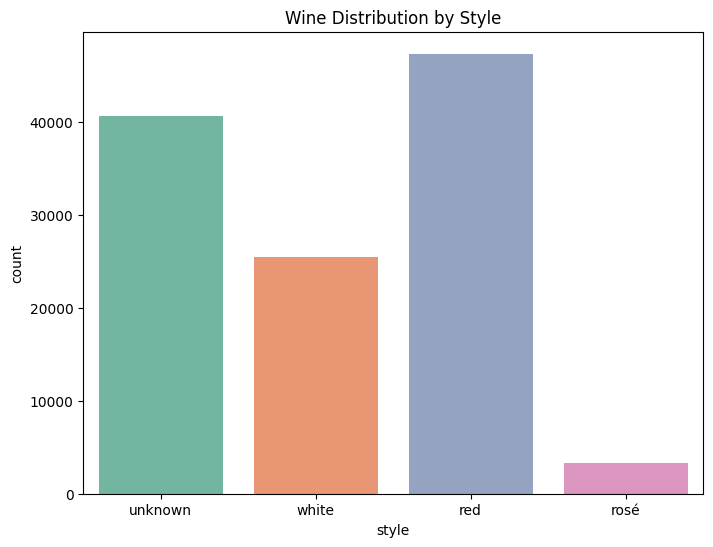

In [ ]:
# Collect wine style data and convert to Pandas
style_data = wine_df.groupBy('style').count().toPandas()

# Plot the count distribution for wine style
plt.figure(figsize=(8, 6))
sns.barplot(x='style', y='count', data=style_data, palette='Set2')
plt.title("Wine Distribution by Style")
plt.show()

<ipython-input-17-f5383098447a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='variety', y='count', data=variety_data, palette='Set2')


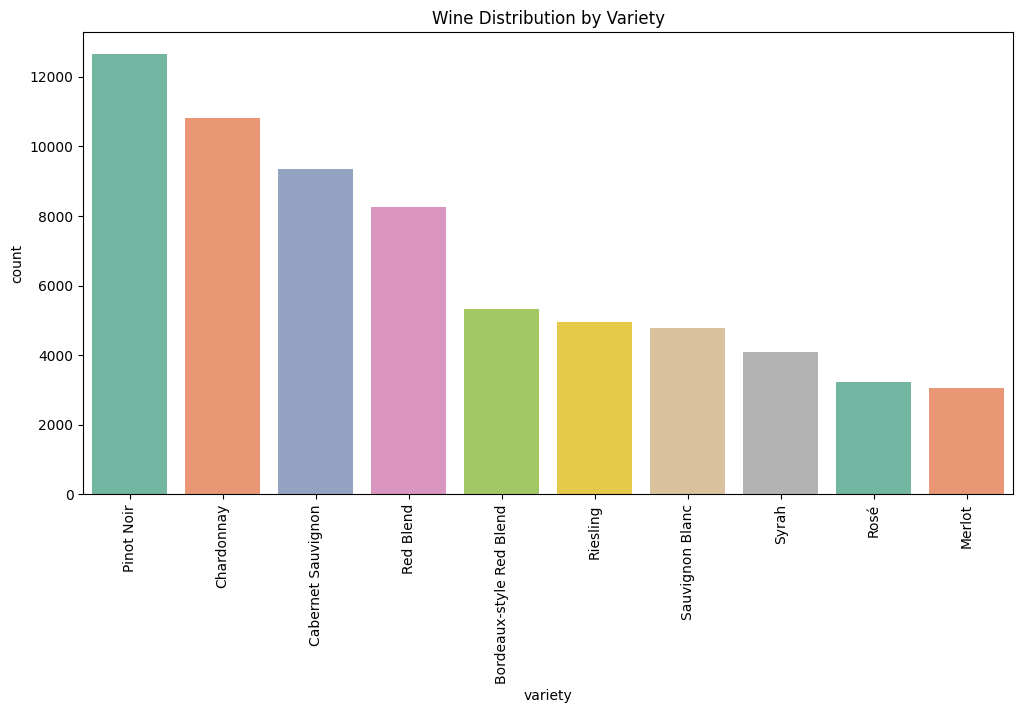

In [ ]:
# Collect wine variety data and convert to Pandas
variety_data = wine_df.groupBy('variety').count().orderBy(col('count').desc()).limit(10).toPandas()

# Plot the count distribution for wine variety
plt.figure(figsize=(12, 6))
sns.barplot(x='variety', y='count', data=variety_data, palette='Set2')
plt.title("Wine Distribution by Variety")
plt.xticks(rotation=90)
plt.show()

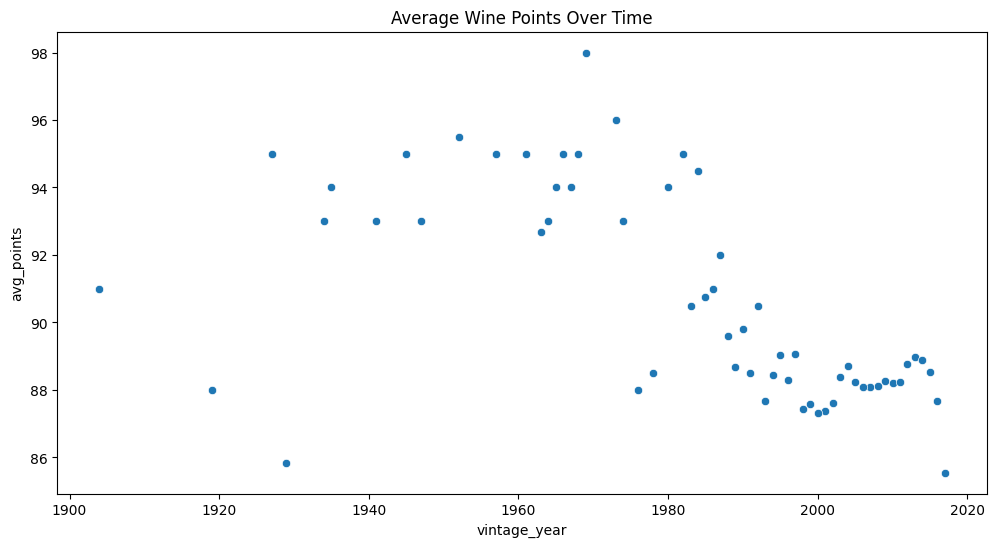

In [ ]:
# Group by vintage year and calculate average points
avg_points_by_vintage = wine_df.groupBy('vintage_year').agg(F.avg('points').alias('avg_points')).toPandas()

# Plot the average points over time
plt.figure(figsize=(12, 6))
sns.scatterplot(x='vintage_year', y='avg_points', data=avg_points_by_vintage, marker='o')
plt.title("Average Wine Points Over Time")
plt.show()

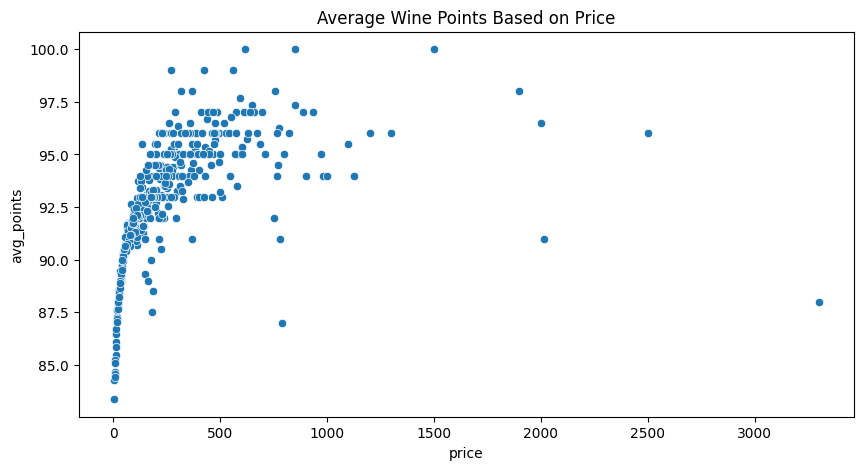

In [ ]:
# Group by price and calculate average points
avg_points_by_price = wine_df.groupBy('price').agg(F.avg('points').alias('avg_points')).toPandas()

# Plot the average points by price
plt.figure(figsize=(10, 5))
sns.scatterplot(x='price', y='avg_points', data=avg_points_by_price, marker='o')
plt.title("Average Wine Points Based on Price")
plt.show()

<Axes: xlabel='points', ylabel='Count'>

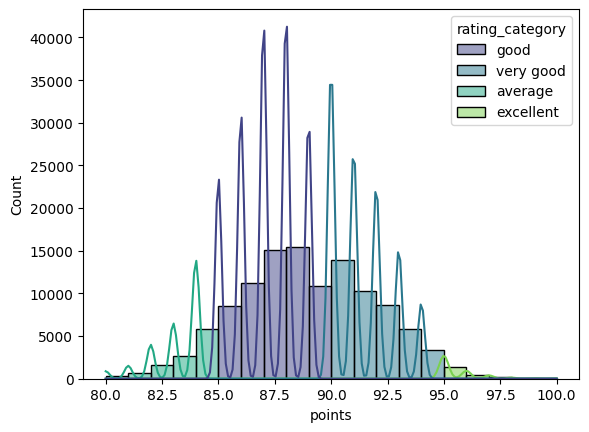

In [ ]:
sns.histplot(data=wine_df.toPandas(), x="points", hue="rating_category", kde=True, palette="viridis", bins=20)

In [ ]:
## Drop columns where style of wine is 'unknown'
wine_df = wine_df[wine_df['style'] != 'unknown']

In [ ]:
# Count occurrences of each value in 'style'
value_counts = wine_df.groupBy("style").count()

# Show the result
value_counts.show()

+-----+-----+
|style|count|
+-----+-----+
|white|25476|
|  red|47346|
| rosé| 3269|
+-----+-----+



In [ ]:
def cat_count(df, cat_col):
    return df.groupBy(cat_col).count().orderBy('count', ascending=False).show()

In [ ]:
cat_count(wine_df, 'winery')

+--------------------+-----+
|              winery|count|
+--------------------+-----+
|          Testarossa|  208|
|     Williams Selyem|  199|
|        Louis Latour|  172|
|  Wines & Winemakers|  169|
|Chateau Ste. Mich...|  163|
|          DFJ Vinhos|  160|
|              Siduri|  126|
|      Columbia Crest|  125|
|        Gary Farrell|  124|
|     Kendall-Jackson|  121|
|              Lynmar|  117|
|       Concha y Toro|  110|
|Chanson Père et Fils|   99|
|Jean-Luc and Paul...|   98|
|          Martin Ray|   96|
|          Dr. Loosen|   95|
|           Undurraga|   92|
|             Kenwood|   91|
|    Casa Santos Lima|   90|
|           Santa Ema|   89|
+--------------------+-----+
only showing top 20 rows

